In [1]:
import numpy as np 
from PIL import Image, ImageDraw, ImageFont 
from skimage import transform as tf

In [2]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Coval-Black.otf", 22) 
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    # Apply scale
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey), mode='constant')
    return image

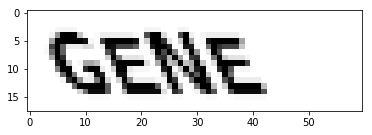

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

In [4]:
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square

def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        # No subimages found, so return the entire image
        return [image,]
    return subimages

In [5]:
subimages = segment_image(image)

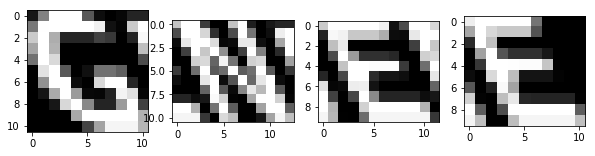

In [6]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

In [7]:
from sklearn.utils import check_random_state
random_state = check_random_state(14) 
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.8, 0.05)
scale_values = np.arange(0.9, 1.1, 0.1)

In [8]:
def generate_sample(random_state=None): 
    random_state = check_random_state(random_state) 
    letter = random_state.choice(letters) 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: L


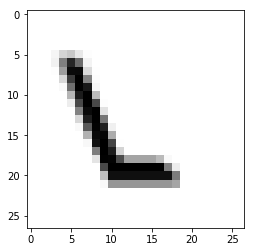

In [9]:
image, target = generate_sample(random_state) 
plt.imshow(image, cmap="Greys") 
print("The target for this image is: {0}".format(letters[target]))

In [10]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float') 
targets = np.array(targets)

C:\Users\Shaarif\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
from sklearn.preprocessing import OneHotEncoder 
onehot = OneHotEncoder() 
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))
y = y.todense()

In [12]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [13]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

C:\Users\Shaarif\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
from keras.layers import Dense
from keras.models import Sequential
hidden_layer = Dense(100, input_dim=X_train.shape[1])
output_layer = Dense(y_train.shape[1])
# Create the model
model = Sequential(layers=[hidden_layer, output_layer])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


In [15]:
model.fit(X_train, y_train, nb_epoch=1000, verbose=False)
y_pred = model.predict(X_test)

C:\Users\Shaarif\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [16]:
from sklearn.metrics import f1_score
f1_score(y_pred=y_pred.argmax(axis=1), y_true=y_test.argmax(axis=1), average='macro')

0.99247863247863255

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_pred=y_pred.argmax(axis=1),
                            y_true=y_test.argmax(axis=1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          2       1.00      1.00      1.00         4
          3       1.00      1.00      1.00         5
          4       1.00      1.00      1.00         2
          5       1.00      1.00      1.00         6
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         2
          8       1.00      1.00      1.00        10
          9       1.00      1.00      1.00         6
         10       1.00      1.00      1.00         3
         11       1.00      1.00      1.00         4
         12       1.00      0.86      0.92         7
         13       1.00      1.00      1.00         2
         14       1.00      1.00      1.00         2
         15       0.80      1.00      0.89         4
         16       1.00      1.00      1.00         3
         17       1.00      1.00      1.00         2
         18       1.00      1.00      1.00   